<b> This notebook performs a mantel test to determine the correlations between each of the PCoAs generated for this project </b>

Notebook by YB & RM

Environment - Qiime2 2018.4

In [ ]:
%matplotlib inline
import qiime2 as q2
import seaborn as sns, numpy as np
from skbio import DistanceMatrix
from skbio.stats.distance import mantel
import pandas as pd

In [58]:
# /Users/rhmills/Documents/Thesis Work/UC_Severity
PREPS = {
    'Serum Proteomics': 'core-metrics-results_Serum/bray_curtis_distance_matrix.qza',
    'Metabolomics': 'pDB_Proteomics/core-metrics-results_Metabolomics/bray_curtis_distance_matrix.qza',
    'Metaproteomics': 'pDB_Proteomics/core-metrics-results_2search/bray_curtis_distance_matrix.qza',
    #'Metagenomics': 'core-metrics-results_MG/bray_curtis_distance_matrix.qza',
    'Metagenomics': 'core-metrics-results-MGall13000/unweighted_unifrac_distance_matrix.qza',
    #'16S': 'Genomics/16S/core-metrics-results_idswap2_newmetadata/unweighted_unifrac_distance_matrix.qza'
    #'16S': 'Genomics/16S/core-metrics-results_idswap2_newmetadata/bray_curtis_distance_matrix.qza'
    '16S':'Genomics/16S/core-metrics-results_idswap2_newmetadata_allsamples/unweighted_unifrac_distance_matrix.qza'
    #'16S':'Genomics/16S/core-metrics-results_idswap2_newmetadata_allsamples/bray_curtis_distance_matrix.qza'
}

In [59]:
dms = {}
for prep, path in PREPS.items():
    dms[prep] = q2.Artifact.load(path).view(DistanceMatrix)
    
# fix the sample ids for the 16S
dms['16S'].ids = [i.replace('11549.', '') for i in dms['16S'].ids]

corr = pd.DataFrame(columns=dms.keys(), index=dms.keys(), dtype=np.float)

#Two samples, H6 and L16, were removed from 16S PCoA analysis because they did not meet rarefaction requirements 
#of <5000 - should be resolved in the allsamples file
shared = set()
for prep, dm in dms.items():
    if len(shared) == 0:
        shared = set(dm.ids)
    else:
        shared &= set(dm.ids)

dms = {prep: dm.filter(shared) for prep, dm in  dms.items()}

In [62]:
len(shared)

40

In [63]:
from itertools import combinations

for prep_a, prep_b in combinations(dms.keys(), 2):
    r, p, n = mantel(dms[prep_a], dms[prep_b])
    
    corr.loc[prep_a, prep_b] = r
    corr.loc[prep_b, prep_a] = r

In [64]:
corr = corr.sort_values(by = ['Serum Proteomics', 'Metabolomics', 'Metagenomics', 'Metaproteomics', '16S'])
corr = corr.sort_values(by = ['Serum Proteomics', 'Metabolomics', 'Metagenomics', 'Metaproteomics', '16S'], axis = 1)

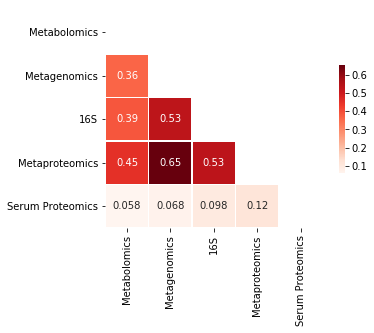

In [65]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask and correct aspect ratio viridis
plot1 = sns.heatmap(corr, mask=mask, cmap='Reds', annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).get_figure()

plot1.savefig('./pdfs/Omics_Heatmap_UniFracMGs.pdf')